In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
import json
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import shap
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from collections.abc import MutableMapping

C:\Users\elyes\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Distributions

In [ ]:
cves = pd.read_csv('data/raw_cves.csv')

## By year

In [18]:
cves['cve.published'] = pd.to_datetime(cves['cve.published'])

In [21]:
cves['year'] = cves['cve.published'].dt.year

<Axes: xlabel='year'>

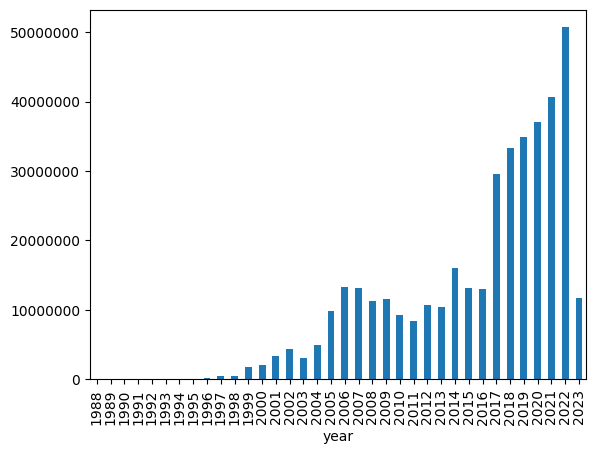

In [121]:
plt.ticklabel_format(style = 'plain')
cves.groupby('year')['year'].sum().plot(kind="bar",grid=False)

## By Severity

In [12]:
v31_base_scores = cves[cves['cve.metrics.cvssMetricV31']==True]['cve.metrics.cvssMetricV31.cvssData.baseSeverity']

<Axes: >

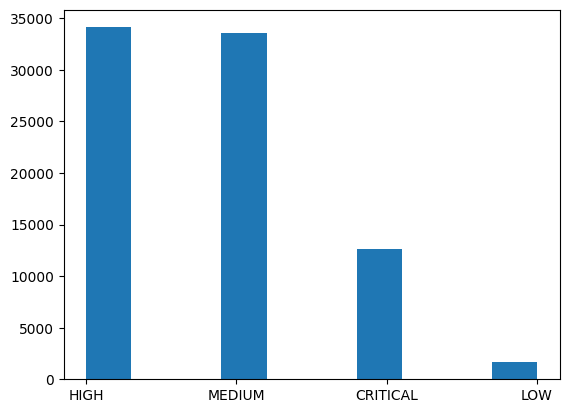

In [13]:
v31_base_scores.hist(grid=False)

## by severity/year

<Axes: xlabel='year'>

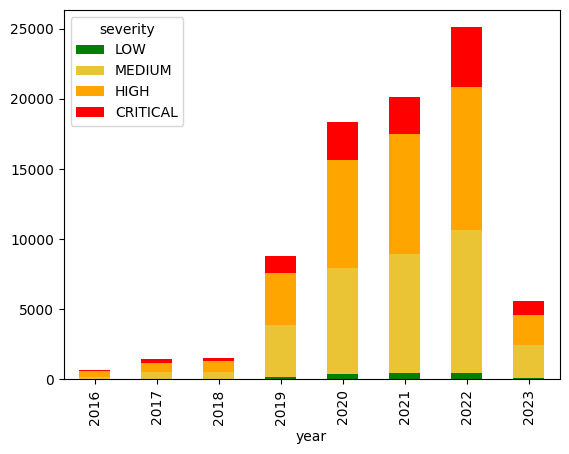

In [117]:
v31_severity = cves[cves['cve.metrics.cvssMetricV31']==True][['cve.metrics.cvssMetricV31.cvssData.baseSeverity',"year"]]
v31_severity['severity'] = v31_severity['cve.metrics.cvssMetricV31.cvssData.baseSeverity']
v31_severity = v31_severity[ v31_severity['year'] >= 2016 ]

v31_severity = v31_severity.groupby('year')['severity'].value_counts().unstack()

v31_severity['l'] = v31_severity['LOW'] 
v31_severity['m'] = v31_severity['MEDIUM'] 
v31_severity['h'] = v31_severity['HIGH'] 
v31_severity['c'] = v31_severity['CRITICAL'] 

v31_severity.drop(['LOW','MEDIUM','CRITICAL','HIGH'],axis=1,inplace=True)
v31_severity.rename(columns={
    'm':'MEDIUM', 'l':'LOW','c':'CRITICAL','h':'HIGH'
},inplace=True)

v31_severity.plot.bar(stacked=True, color=['green','#EAC435','orange','red'])

# Description length distribution

In [7]:
descriptions = pd.read_csv('data/raw_cves.csv', usecols=['cve.descriptions.lang.en'])

In [12]:
descriptions['length'] = descriptions["cve.descriptions.lang.en"].str.len()

array([[<Axes: title={'center': 'length'}>]], dtype=object)

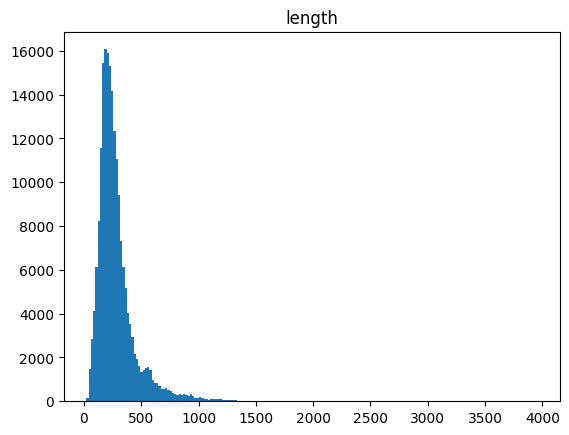

In [48]:
descriptions.hist(column='length', grid=False, bins=200)

# Label Distribution

In [1]:
labels = ['attackComplexity', 'attackVector', 'availabilityImpact', 'confidentialityImpact',
          'integrityImpact', 'privilegesRequired', 'scope', 'userInteraction']

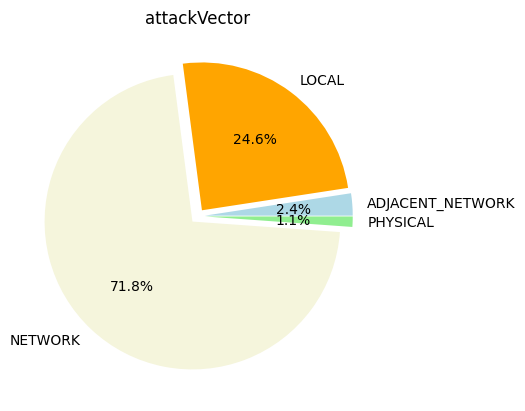

In [65]:
label = labels[1]
with open(f'data/{label}/label_mapping.txt') as f:
    content = f.read().replace("'",'"')
    class_names = list(json.loads(content).keys())

train = pd.read_csv(f'data/{label}/train.csv')
test = pd.read_csv(f'data/{label}/test.csv')
alltext = pd.concat([train,test])

thedict = {}
for i,c in enumerate(class_names):
    thedict.update({
        i:c
    })

alltext['labels'] = alltext['labels'].map(thedict)

d = dict(alltext.groupby('labels').size())
classes = list(d.keys())
values = list(d.values())
myexplode = [0.05,0.05,0.05,0.05]
colors=['lightblue','orange','beige','lightgreen']
plt.pie(values, labels = classes, autopct='%1.1f%%' , explode = myexplode, colors=colors)
plt.title(label)
plt.show() 

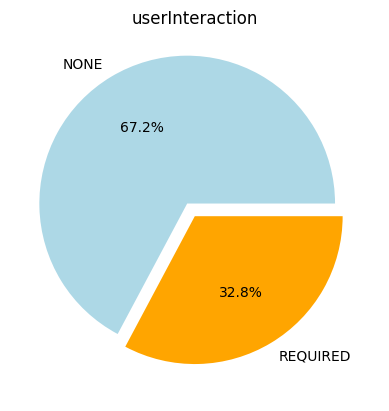

## frequency in-class

In [ ]:
labels = ['attackComplexity', 'attackVector', 'availabilityImpact', 'confidentialityImpact',
          'integrityImpact', 'privilegesRequired', 'scope', 'userInteraction']

,text,labels
0,Use after free in tab strip in Google Chrome p...,REQUIRED
1,Microsoft Edge (Chromium-based) Elevation of P...,REQUIRED
2,"In modules/imgcodecs/src/grfmt_pxm.cpp, the le...",REQUIRED
3,Draytek VigorAP 1000C contains a stored cross-...,REQUIRED
4,The ThemeMakers Accio Responsive Parallax One ...,NONE
